<a href="https://colab.research.google.com/github/tyagiabhishek134/Tacotron2/blob/main/Tacotron2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.3 MB/s eta 0:00:00


In [5]:
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, TimeDistributed, Bidirectional, Conv1D, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow_addons.seq2seq import BahdanauAttention

# Function to load metadata
def load_ljs(data_path):
    metadata_file = os.path.join(data_path, 'list.txt')
    with open(metadata_file, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    metadata = []
    for line in lines:
        parts = line.strip().split('|')
        if len(parts) == 2:
            metadata.append(parts)
        else:
            print("Skipping line due to format error.")
    return metadata

# Function to normalize text
def normalize_text(text):
    text = text.lower()
    text = text.replace('.', ' ')
    return text

# Function to convert text to sequences
def text_to_sequences(texts, tokenizer):
    sequences = tokenizer.texts_to_sequences(texts)
    return sequences

# Function to convert audio to mel spectrogram
def audio_to_mel(audio_path):
    y, sr = librosa.load(audio_path, sr=22050)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=80)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db

# Function to preprocess dataset
def preprocess_dataset(data_path, tokenizer):
    metadata = load_ljs(data_path)
    texts = [normalize_text(m[1]) for m in metadata]
    audio_paths = [os.path.join(data_path, m[0]) for m in metadata]
    sequences = text_to_sequences(texts, tokenizer)
    mels = [audio_to_mel(audio_path) for audio_path in audio_paths]
    return sequences, mels

# Function to normalize mel spectrogram
def normalize_mel(mel):
    mean = np.mean(mel, axis=0)
    std = np.std(mel, axis=0)
    return (mel - mean) / std



In [6]:
data_path = '/content/drive/MyDrive/tts_COPY_data/wavs'
tokenizer = Tokenizer(char_level=True)
texts = [normalize_text(m[1]) for m in load_ljs(data_path)]
tokenizer.fit_on_texts(texts)

sequences, mels = preprocess_dataset(data_path, tokenizer)



import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model

embedding_dim = 256
lstm_units = 256
n_mels = 80


text_input=Input(shape=(None,), name='text_input')
embedding=Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=embedding_dim)(text_input)
encoder_lstm=LSTM(lstm_units, return_sequences=True, return_state=True)
encoder_output, state_h, state_c = encoder_lstm(embedding)

decoder_input=Input(shape=(None, n_mels), name='decoder_input')
decoder_lstm=LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_output,_,_=decoder_lstm(decoder_input, initial_state=[state_h, state_c])

mel_output=TimeDistributed(Dense(n_mels))(decoder_output)

model=Model(inputs=[text_input, decoder_input], outputs=mel_output
            )
model.compile(optimizer='adam', loss='mse'
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, None)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, None, 256)            12544     ['text_input[0][0]']          
                                                                                                  
 decoder_input (InputLayer)  [(None, None, 80)]           0         []                            
                                                                                                  
 lstm_2 (LSTM)               [(None, None, 256),          525312    ['embedding_1[0][0]']         
                              (None, 256),                                                    

Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 0.9167 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - 0s 252ms/step - loss: 0.9166 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - 0s 210ms/step - loss: 0.9165 - lr: 0.0010
Epoch 4/100
1/1 [==============================] - 0s 331ms/step - loss: 0.9163 - lr: 0.0010
Epoch 5/100
1/1 [==============================] - 1s 500ms/step - loss: 0.9162 - lr: 0.0010
Epoch 6/100
1/1 [==============================] - 0s 257ms/step - loss: 0.9160 - lr: 0.0010
Epoch 7/100
1/1 [==============================] - 0s 228ms/step - loss: 0.9158 - lr: 0.0010
Epoch 8/100
1/1 [==============================] - 0s 247ms/step - loss: 0.9155 - lr: 0.0010
Epoch 9/100
1/1 [==============================] - 0s 227ms/step - loss: 0.9151 - lr: 0.0010
Epoch 10/100
1/1 [==============================] - 0s 243ms/step - loss: 0.9147 - lr: 0.0010
Epoch 11/100
1/1 [==============================] - 0s 218ms/step - loss

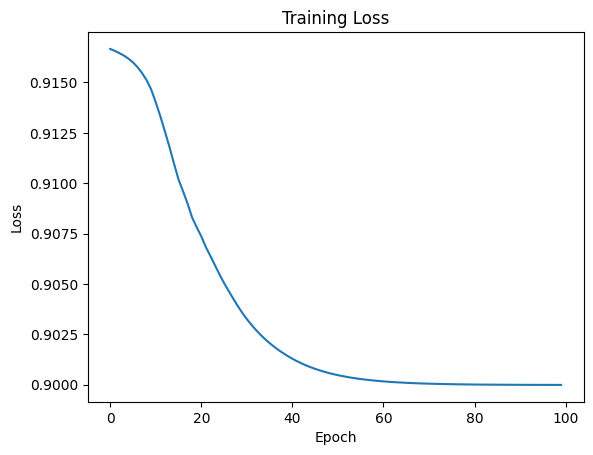

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import librosa

# Define the Tacotron2 model
class Tacotron2(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, encoder_dim, decoder_dim, mel_dim):
        super(Tacotron2, self).__init__()
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.encoder_lstm = LSTM(encoder_dim, return_sequences=True, return_state=True)
        self.decoder_lstm = LSTM(decoder_dim, return_sequences=True, return_state=True)
        self.dense = TimeDistributed(Dense(mel_dim))

    def call(self, inputs, training=False):
        sequences, decoder_input = inputs
        embedded_sequences = self.embedding(sequences)
        encoder_outputs, state_h, state_c = self.encoder_lstm(embedded_sequences)
        decoder_outputs, _, _ = self.decoder_lstm(decoder_input, initial_state=[state_h, state_c])
        outputs = self.dense(decoder_outputs)
        return outputs

# Function to normalize mel spectrogram
def normalize_mel(mel):
    mean = np.mean(mel, axis=0)
    std = np.std(mel, axis=0)
    return (mel - mean) / std

# Adjust the data generator to normalize mel spectrograms
def data_generator(sequences, mels, batch_size, n_mels):
    num_samples = len(sequences)
    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)

        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]

            batch_sequences = [sequences[i] for i in batch_indices]
            batch_mels = [normalize_mel(mels[i]) for i in batch_indices]

            max_len_seq = max(len(seq) for seq in batch_sequences)
            max_len_mel = max(mel.shape[0] for mel in batch_mels)

            batch_sequences_padded = np.array([
                np.pad(seq, (0, max_len_seq - len(seq)), 'constant', constant_values=0)
                for seq in batch_sequences
            ], dtype=np.int32)
            batch_mels_padded = np.zeros((len(batch_sequences), max_len_mel, n_mels), dtype=np.float32)
            for j, mel in enumerate(batch_mels):
                batch_mels_padded[j, :mel.shape[0], :] = mel

            decoder_input = np.zeros((len(batch_sequences), max_len_mel, n_mels), dtype=np.float32)

            yield [batch_sequences_padded, decoder_input], batch_mels_padded

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Training parameters
vocab_size = 40  # Adjust based on your tokenizer
embedding_dim = 256
encoder_dim = 256
decoder_dim = 256
mel_dim = 80
batch_size = 32
epochs = 100

# Initialize and compile the model
tacotron2 = Tacotron2(vocab_size, embedding_dim, encoder_dim, decoder_dim, mel_dim)
tacotron2.compile(optimizer='adam', loss='mse')

# Generate some dummy data for testing
text_sequences = [[1, 2, 3, 4], [5, 6, 7]]  # Replace with your actual text sequences
mels = [np.random.rand(100, 80), np.random.rand(120, 80)]  # Replacewith youractualmelspectrograms

steps_per_epoch = int(np.ceil(len(text_sequences) / batch_size))

# Learning rate scheduler callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Training
history = tacotron2.fit(
    data_generator(text_sequences, mels, batch_size, mel_dim),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    callbacks=[lr_callback]
)

# Plot training loss
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

1/1 [==============================] - 1s 879ms/step


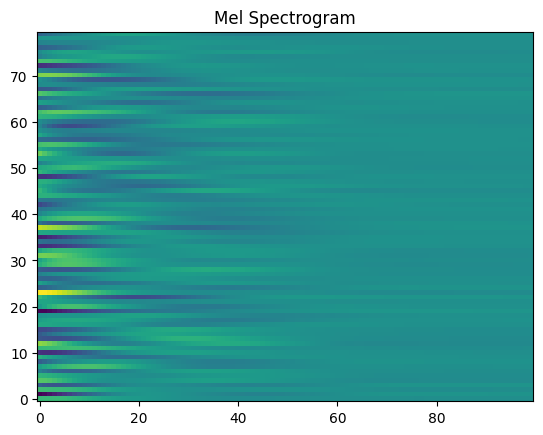

In [8]:
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer

# Function to normalize text
def normalize_text(text):
    text = text.lower()
    text = text.replace('.', '')
    return text

# Function to convert text to sequences using the tokenizer
def text_to_sequences(texts, tokenizer):
    sequences = tokenizer.texts_to_sequences(texts)
    return sequences

# Function to generate mel spectrogram from text
def generate_mel(text, tokenizer, model, max_len_seq=100, n_mels=80):
    sequence = text_to_sequences([normalize_text(text)], tokenizer)
    sequence_padded = np.pad(sequence[0], (0, max_len_seq - len(sequence[0])), 'constant')
    sequence_padded = np.expand_dims(sequence_padded, axis=0)

    decoder_input = np.zeros((1, max_len_seq, n_mels), dtype=np.float32)

    mel = model.predict([sequence_padded, decoder_input])
    return mel[0]

# Function to convert mel spectrogram to audio using Griffin-Lim algorithm
def mel_to_audio(mel, sr=22050, n_iter=32):
    mel= np.exp(mel)
    audio = librosa.feature.inverse.mel_to_audio(mel, sr=sr, n_iter=n_iter)
    return audio

# Example usage
text = "HAS NEVER BEEN SURPASSED"

# Generate mel spectrogram from text
mel = generate_mel(text, tokenizer, tacotron2)

# Display mel spectrogram
plt.imshow(mel.T, aspect='auto', origin='lower')
plt.title('Mel Spectrogram')
plt.show()

# Convert mel spectrogram to audio
audio = mel_to_audio(mel)

# Save audio to file
sf.write('output.wav', audio, 22050)

# Optionally, play audio
import IPython.display as ipd
ipd.Audio(audio, rate=22050)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')